# Understanding the Business Problem
TalkingData is a Chinese big data company, and one of their areas of expertise is mobile advertisements.

In mobile advertisements, click fraud is a major source of losses. Click fraud is the practice of repeatedly clicking on an advertisement hosted on a website with the intention of generating revenue for the host website or draining revenue from the advertiser.

In this case, TalkingData happens to be serving the advertisers (their clients). TalkingData cover a whopping approx. 70% of the active mobile devices in China, of which 90% are potentially fraudulent (i.e. the user is actually not going to download the app after clicking).

You can imagine the amount of money they can help clients save if they are able to predict whether a given click is fraudulent (or equivalently, whether a given click will result in a download).

Their current approach to solve this problem is that they've generated a blacklist of IP addresses - those IPs which produce lots of clicks, but never install any apps. Now, they want to try some advanced techniques to predict the probability of a click being genuine/fraud.

In this problem, we will use the features associated with clicks, such as IP address, operating system, device type, time of click etc. to predict the probability of a click being fraud.

They have released the problem on Kaggle here..

# The data contains observations of about 240 million clicks, and whether a given click resulted in a download or not (1/0).

On Kaggle, the data is split into train.csv and train_sample.csv (100,000 observations). We'll use the smaller train_sample.csv in this notebook for speed, though while training the model for Kaggle submissions, the full training data will obviously produce better results.

The detailed data dictionary is mentioned here:

ip: ip address of click.
app: app id for marketing.
device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
os: os version id of user mobile phone
channel: channel id of mobile ad publisher
click_time: timestamp of click (UTC)
attributed_time: if user download the app for after clicking an ad, this is the time of the app download
is_attributed: the target that is to be predicted, indicating the app was downloaded

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv(r'C:\Users\Ajit\Downloads/train_sample.csv')

In [3]:
df

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0
...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,NaN,0
99996,85150,9,1,13,244,2017-11-07 11:25:43,NaN,0
99997,18839,3,1,13,19,2017-11-08 11:38:42,NaN,0
99998,114276,15,1,12,245,2017-11-08 17:55:21,NaN,0


In [4]:
df.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [5]:
df.tail()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
99995,124883,11,1,19,122,2017-11-09 13:25:41,NaN,0
99996,85150,9,1,13,244,2017-11-07 11:25:43,NaN,0
99997,18839,3,1,13,19,2017-11-08 11:38:42,NaN,0
99998,114276,15,1,12,245,2017-11-08 17:55:21,NaN,0
99999,119349,14,1,15,401,2017-11-07 14:32:27,NaN,0


In [6]:
df.sample()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
7010,21992,15,1,17,111,2017-11-09 02:26:43,NaN,0


In [7]:
df.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [8]:
attributed_time=df['attributed_time'].mode()
df['attributed_time'].fillna(value=attributed_time[0],inplace=True)
df['attributed_time'].mode()


0    2017-11-06 17:19:04
dtype: object

In [9]:
df.describe

<bound method NDFrame.describe of            ip  app  device  os  channel           click_time  \
0       87540   12       1  13      497  2017-11-07 09:30:38   
1      105560   25       1  17      259  2017-11-07 13:40:27   
2      101424   12       1  19      212  2017-11-07 18:05:24   
3       94584   13       1  13      477  2017-11-07 04:58:08   
4       68413   12       1   1      178  2017-11-09 09:00:09   
...       ...  ...     ...  ..      ...                  ...   
99995  124883   11       1  19      122  2017-11-09 13:25:41   
99996   85150    9       1  13      244  2017-11-07 11:25:43   
99997   18839    3       1  13       19  2017-11-08 11:38:42   
99998  114276   15       1  12      245  2017-11-08 17:55:21   
99999  119349   14       1  15      401  2017-11-07 14:32:27   

           attributed_time  is_attributed  
0      2017-11-06 17:19:04              0  
1      2017-11-06 17:19:04              0  
2      2017-11-06 17:19:04              0  
3      2017-11-06 17:

In [10]:
df.info

<bound method DataFrame.info of            ip  app  device  os  channel           click_time  \
0       87540   12       1  13      497  2017-11-07 09:30:38   
1      105560   25       1  17      259  2017-11-07 13:40:27   
2      101424   12       1  19      212  2017-11-07 18:05:24   
3       94584   13       1  13      477  2017-11-07 04:58:08   
4       68413   12       1   1      178  2017-11-09 09:00:09   
...       ...  ...     ...  ..      ...                  ...   
99995  124883   11       1  19      122  2017-11-09 13:25:41   
99996   85150    9       1  13      244  2017-11-07 11:25:43   
99997   18839    3       1  13       19  2017-11-08 11:38:42   
99998  114276   15       1  12      245  2017-11-08 17:55:21   
99999  119349   14       1  15      401  2017-11-07 14:32:27   

           attributed_time  is_attributed  
0      2017-11-06 17:19:04              0  
1      2017-11-06 17:19:04              0  
2      2017-11-06 17:19:04              0  
3      2017-11-06 17:19

In [11]:
df.isnull().sum()

ip                 0
app                0
device             0
os                 0
channel            0
click_time         0
attributed_time    0
is_attributed      0
dtype: int64

In [12]:
df.isnull().sum()

ip                 0
app                0
device             0
os                 0
channel            0
click_time         0
attributed_time    0
is_attributed      0
dtype: int64

<AxesSubplot:>

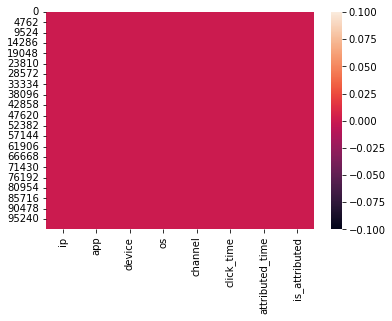

In [13]:
sns.heatmap(df.isnull())


<AxesSubplot:>

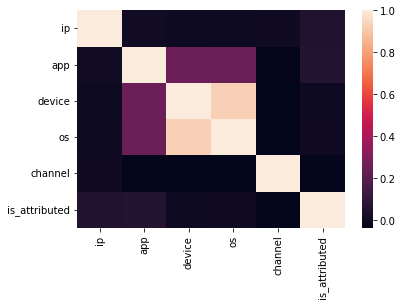

In [14]:
sns.heatmap(df.corr())

C:\Users\Ajit\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

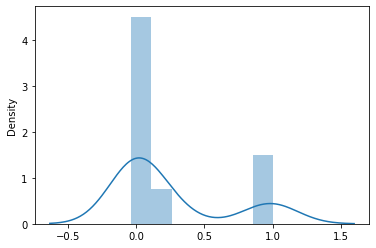

In [15]:
sns.distplot(df.corr())

In [16]:
df


,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,2017-11-06 17:19:04,0
1,105560,25,1,17,259,2017-11-07 13:40:27,2017-11-06 17:19:04,0
2,101424,12,1,19,212,2017-11-07 18:05:24,2017-11-06 17:19:04,0
3,94584,13,1,13,477,2017-11-07 04:58:08,2017-11-06 17:19:04,0
4,68413,12,1,1,178,2017-11-09 09:00:09,2017-11-06 17:19:04,0
...,...,...,...,...,...,...,...,...
99995,124883,11,1,19,122,2017-11-09 13:25:41,2017-11-06 17:19:04,0
99996,85150,9,1,13,244,2017-11-07 11:25:43,2017-11-06 17:19:04,0
99997,18839,3,1,13,19,2017-11-08 11:38:42,2017-11-06 17:19:04,0
99998,114276,15,1,12,245,2017-11-08 17:55:21,2017-11-06 17:19:04,0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  100000 non-null  object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [18]:
df.click_time

0        2017-11-07 09:30:38
1        2017-11-07 13:40:27
2        2017-11-07 18:05:24
3        2017-11-07 04:58:08
4        2017-11-09 09:00:09
                ...         
99995    2017-11-09 13:25:41
99996    2017-11-07 11:25:43
99997    2017-11-08 11:38:42
99998    2017-11-08 17:55:21
99999    2017-11-07 14:32:27
Name: click_time, Length: 100000, dtype: object

In [19]:
df.is_attributed.value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

# OrdinalEencoding technique 

In [20]:
from sklearn.preprocessing import OrdinalEncoder

In [21]:
ord_enc=OrdinalEncoder()

In [22]:
df["click_time1"]=ord_enc.fit_transform(df[["click_time"]])

In [23]:
df[["click_time", "click_time1"]].head(100000)

,click_time,click_time1
0,2017-11-07 09:30:38,17415.0
1,2017-11-07 13:40:27,23123.0
2,2017-11-07 18:05:24,27844.0
3,2017-11-07 04:58:08,11508.0
4,2017-11-09 09:00:09,70545.0
...,...,...
99995,2017-11-09 13:25:41,76690.0
99996,2017-11-07 11:25:43,20091.0
99997,2017-11-08 11:38:42,46757.0
99998,2017-11-08 17:55:21,54934.0


In [24]:
df.dropna(axis='columns',inplace=True)

In [25]:
from sklearn.model_selection import train_test_split 

In [26]:
X=df.drop(['attributed_time', 'is_attributed','click_time'],axis=1)

In [27]:
X

,ip,app,device,os,channel,click_time1
0,87540,12,1,13,497,17415.0
1,105560,25,1,17,259,23123.0
2,101424,12,1,19,212,27844.0
3,94584,13,1,13,477,11508.0
4,68413,12,1,1,178,70545.0
...,...,...,...,...,...,...
99995,124883,11,1,19,122,76690.0
99996,85150,9,1,13,244,20091.0
99997,18839,3,1,13,19,46757.0
99998,114276,15,1,12,245,54934.0


In [28]:
y=df['is_attributed']

# import standardscaler

In [29]:
from sklearn.preprocessing import StandardScaler


In [30]:
scaler=StandardScaler()

In [31]:
x_scaled=scaler.fit_transform(X)

In [32]:
x_scaled

array([[-0.05320926, -0.00320451, -0.07999204, -0.17550552,  1.75887457,
        -0.994075  ],
       [ 0.20482678,  0.86685974, -0.07999204, -0.10400399, -0.07579546,
        -0.74772348],
       [ 0.14560164, -0.00320451, -0.07999204, -0.06825322, -0.43810425,
        -0.54396989],
       ...,
       [-1.03696811, -0.60555669, -0.07999204, -0.17550552, -1.92588288,
         0.27229609],
       [ 0.3296349 ,  0.19757955, -0.07999204, -0.1933809 , -0.18371723,
         0.62520715],
       [ 0.40227734,  0.13065153, -0.07999204, -0.13975475,  1.0188396 ,
        -0.69554426]])

In [33]:
df.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed', 'click_time1'],
      dtype='object')

In [34]:
df.shape

(100000, 9)

In [35]:
X_train,X_test,y_train,y_test=train_test_split(x_scaled,y,test_size=0.25,random_state=101)

In [36]:
X_train.shape

(75000, 6)

In [37]:
y_train.value_counts()

0    74827
1      173
Name: is_attributed, dtype: int64

# import DecisionTreeClassifier

In [38]:
from sklearn.tree import DecisionTreeClassifier


# import cross_val_score

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
scores=cross_val_score(DecisionTreeClassifier(),X,y,cv=6)

In [41]:
scores

array([0.99706006, 0.99688006, 0.99640007, 0.99682006, 0.99687988,
       0.9974199 ])

# import BaggingClassifier

In [42]:
from sklearn.ensemble import BaggingClassifier

In [43]:
 bag_model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                   n_estimators=100,
                   max_samples=0.5,
                   oob_score=True,
                   random_state=0)

In [44]:
bag_model

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5,
                  n_estimators=100, oob_score=True, random_state=0)

In [45]:
bag_model.fit(X_train,y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=0.5,
                  n_estimators=100, oob_score=True, random_state=0)

In [46]:
bag_model.oob_score_

0.9978533333333334

In [47]:
bag_model=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                   n_estimators=100,
                   max_samples=0.5,
                   oob_score=True,
                   random_state=0)
score1=cross_val_score(bag_model,X,y,cv=6)

In [48]:
score1

array([0.99826003, 0.99814004, 0.99760005, 0.99796004, 0.99765991,
       0.99819993])